In [ ]:
from pathlib import Path
import numpy as np
import xarray as xr
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Circle
import xclimate as xclim

In [ ]:
variables = [
    "EFLX_LH_TOT_month_1",
    "PRECC_month_1", "PRECL_month_1",
    "FSDS_month_1", "FSR_month_1", "FLDS_month_1", "FIRE_month_1",  # for net radiation
]

time_slice = slice("1995-01", "2014-12")
year_start = time_slice.start[:4]
year_end = time_slice.stop[:4]
grid = xclim.load_fhist_ppe_grid()

snow_pct_threshold = 80    # maximum allowable percent of snow cover on all months of the average year
nonglc_pct_threshold = 80  # maximum allowable percent of glaciated land for a NON-glaciated gridcell

fsno = xclim.load_fhist("FSNO_month_1", keep_var_only=True)["FSNO"].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
fsno_clim_min = fsno.groupby("time.month").mean().min(dim="month")

# Create masks
snow_mask = fsno_clim_min <= (snow_pct_threshold / 100)
nonglc_mask = grid.PCT_GLC <= nonglc_pct_threshold
full_mask = snow_mask & nonglc_mask

fhist = {}
for v in variables:
    print(f"  {v}")
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
    fhist[v] = fhist[v].where(full_mask)
    fhist[v].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}\ngridcell percent snow cover on all months of average year <= {snow_pct_threshold}"

fhist["EFLX_LH_TOT_year_1"] = fhist["EFLX_LH_TOT_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

# Monthly PRECT (PRECC + PRECL)
print("  PRECT_month_1")
fhist["PRECT_month_1"] = fhist["PRECC_month_1"] + fhist["PRECL_month_1"]
fhist["PRECT_month_1"].attrs["long_name"] = "total monthly precipitation rate (PRECC + PRECL)"
fhist.pop("PRECC_month_1")
fhist.pop("PRECL_month_1")

# Monthly net radiation at the surface, + down
#   Rn = (net SW) + (net LW) = (down SW - up SW) - (down LW - up LW)
#   Rn = FSDS - FSR + FLDS - FIRE
print("  RN_month_1")
fhist["RN_month_1"] = fhist["FSDS_month_1"] - fhist["FSR_month_1"] + fhist["FLDS_month_1"] - fhist["FIRE_month_1"]
fhist["RN_month_1"] = fhist["RN_month_1"].rename("RN")
fhist["RN_month_1"].attrs = {
    "long_name": "net radiation at surface [+ down]",
    "description": "FSDS - FSR + FLDS - FIRE",
    "units": "W/m2",
}
fhist["RN_month_1"] = fhist["RN_month_1"].compute()

# Climatological net radiation at the surface
print("  RN_clim_1")
fhist["RN_clim_1"] = fhist["RN_month_1"].weighted(fhist["RN_month_1"].time.dt.days_in_month).mean("time")
fhist["RN_clim_1"].attrs["time_mean"] = f"{time_slice.start} to {time_slice.stop}"

# Monthly precipitation rate in energy units
print("  EPRECT_month_1")
fhist["EPRECT_month_1"] = fhist["PRECT_month_1"] * 1000 * 2.5e6
fhist["EPRECT_month_1"] = xr.where(fhist["EPRECT_month_1"] < 1e-3, 1e-3, fhist["EPRECT_month_1"])
fhist["EPRECT_month_1"].attrs = {
    "long_name": f"{fhist['PRECT_month_1'].attrs['long_name']} in energy units",
    "units": "W/m2"
}

# Climatological precipitation rate in energy units
print("  EPRECT_clim_1")
fhist["EPRECT_clim_1"] = fhist["EPRECT_month_1"].weighted(fhist["EPRECT_month_1"].time.dt.days_in_month).mean("time")
fhist["EPRECT_clim_1"].attrs = {
    "long_name": f"{fhist['PRECT_month_1'].attrs['long_name']} in energy units",
    "time_mean": f"{time_slice.start} to {time_slice.stop}",
}

# Climatological aridity index (AI = PET / P = RN / EPRECT)
print("  AI_clim_1")
fhist["AI_clim_1"] = fhist["RN_clim_1"] / fhist["EPRECT_clim_1"]
fhist["AI_clim_1"] = fhist["AI_clim_1"].rename("AI")
fhist["AI_clim_1"].attrs = {
    "long_name": "aridity index PET/P, higher is more arid",
    "description": "Rn / (Lv * P), filtered P = max(P, 0.001) [W/m2]",
    "time_mean": f"{time_slice.start} to {time_slice.stop}"
}
fhist["AI_clim_1"] = fhist["AI_clim_1"].compute()

  EFLX_LH_TOT_month_1
  PRECC_month_1
  PRECL_month_1
  FSDS_month_1
  FSR_month_1
  FLDS_month_1
  FIRE_month_1
  PRECT_month_1
  RN_month_1
  RN_clim_1
  EPRECT_month_1
  EPRECT_clim_1
  AI_clim_1


Text(0.5, 1.0, 'lowest aridity index bin grid cells')

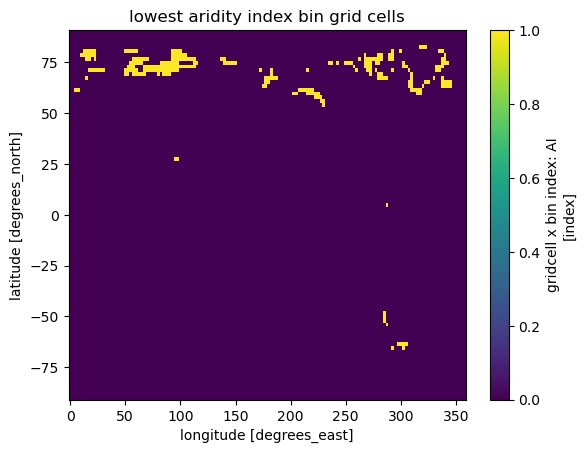

In [ ]:
(xbe.isel(year=0) == 0).plot()
plt.title("lowest aridity index bin grid cells")

Text(0.5, 1.0, 'lowest aridity index bin grid cells\nmasked with stricter glc and snow thresholds')

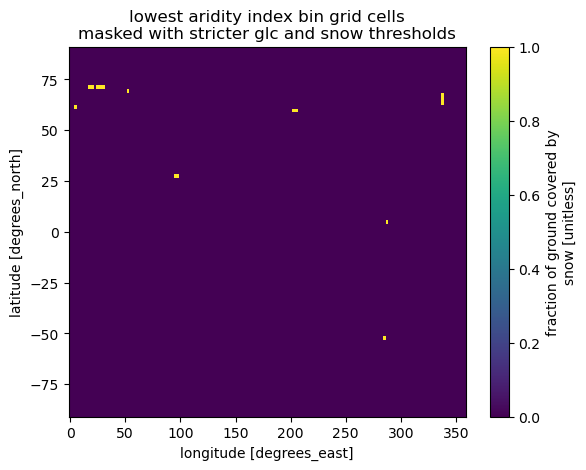

In [ ]:
((xbe.isel(year=0) == 0) & (grid.PCT_GLC == 0) & (fsno_clim_min.sel(member=m) == 0)).plot()
plt.title("lowest aridity index bin grid cells\nmasked with stricter glc and snow thresholds")

Text(0.5, 1.0, 'climatological Rn')

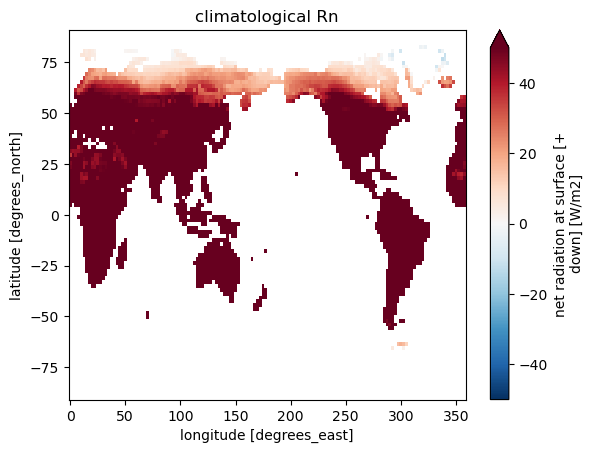

In [ ]:
fhist["RN_clim_1"].sel(member=m).plot(robust=True, vmin=-50, vmax=50, cmap='RdBu_r')
plt.title("climatological Rn")

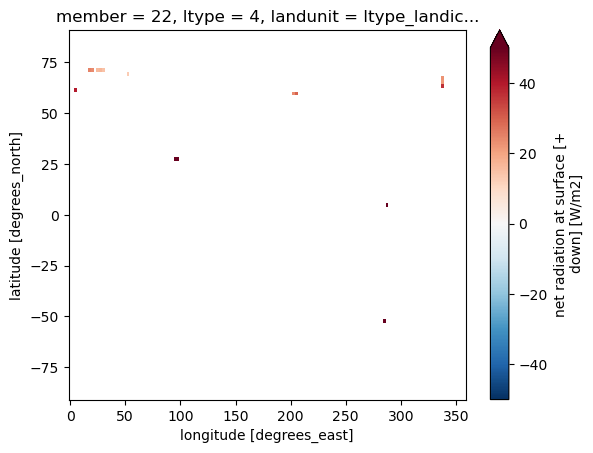

In [ ]:
fhist["RN_clim_1"].sel(member=m).where((xbe.isel(year=0) == 0) & (grid.PCT_GLC == 0) & (fsno_clim_min.sel(member=m) == 0)).plot(robust=True, vmin=-50, vmax=50, cmap='RdBu_r')

In [ ]:
fhist["RN_clim_1"].sel(member=m).where((xbe.isel(year=0) == 0) & (grid.PCT_GLC == 0) & (fsno_clim_min.sel(member=m) == 0)).mean().values

array(37.984414)

In [ ]:
fhist["RN_clim_1"].sel(member=m).where(xbe.isel(year=0) == 0).mean().values

array(10.73624099)

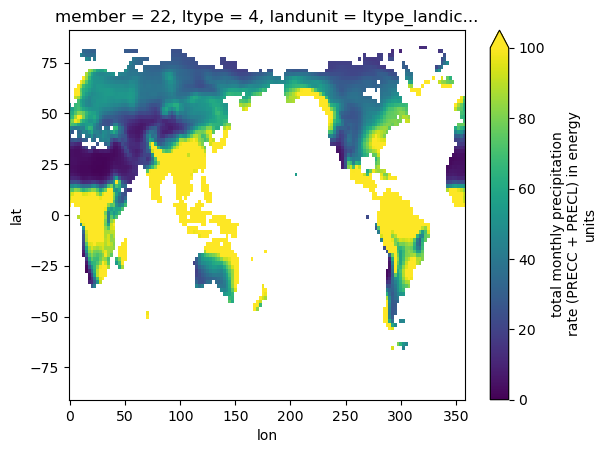

In [ ]:
fhist["EPRECT_clim_1"].sel(member=m).plot(vmin=0, vmax=100)

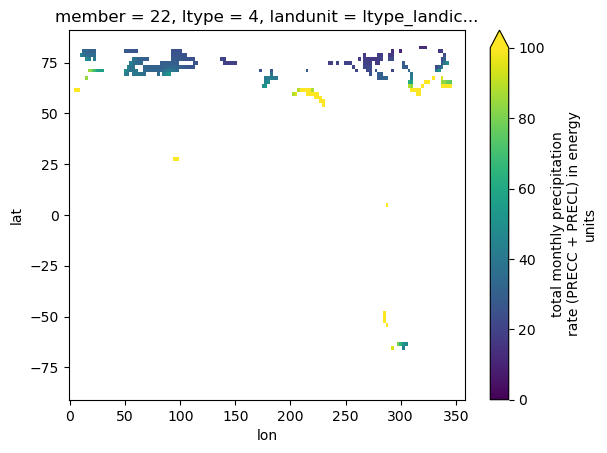

In [ ]:
fhist["EPRECT_clim_1"].sel(member=m).where(xbe.isel(year=0) == 0).plot(vmin=0, vmax=100)

In [ ]:
fhist["EPRECT_clim_1"].sel(member=m).where(xbe.isel(year=0) == 0).mean().values

array(53.09349528)

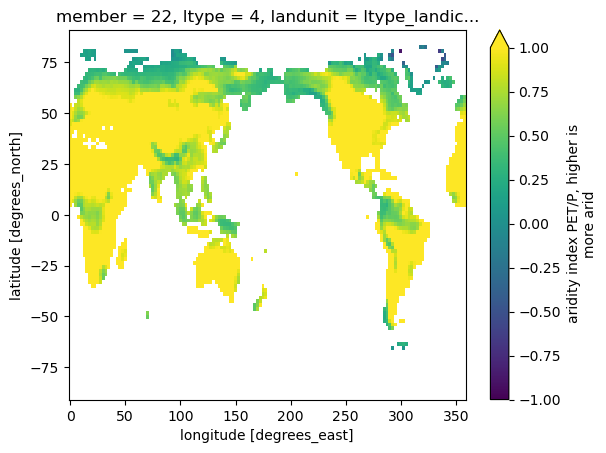

In [ ]:
fhist["AI_clim_1"].sel(member=m).plot(robust=True, vmin=-1, vmax=1)

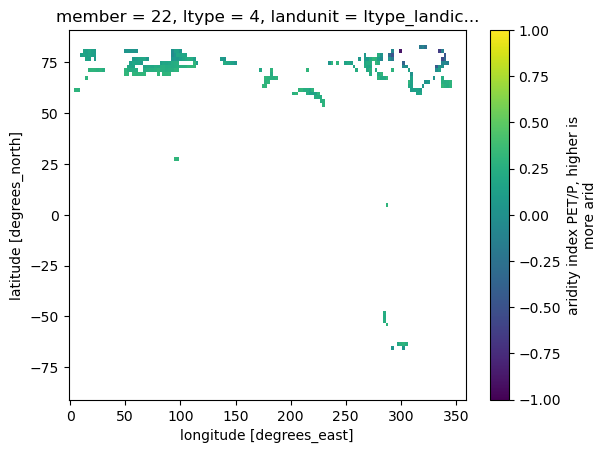

In [ ]:
fhist["AI_clim_1"].sel(member=m).where(xbe.isel(year=0) == 0).plot(robust=True, vmin=-1, vmax=1)

In [ ]:
fhist["AI_clim_1"].sel(member=m).where(xbe.isel(year=0) == 0).mean().values

array(0.1652692)

In [ ]:
fhist["AI_clim_1"].sel(member=m).where(xbe.isel(year=0) == 1).mean().values

array(0.37699087)

In [ ]:
fhist["AI_clim_1"].sel(member=m).where(xbe.isel(year=0) == 2).mean().values

array(0.50260134)

In [ ]:
fhist["AI_clim_1"].sel(member=m).where(xbe.isel(year=0) == 10).mean().values

array(1.59863945)

In [ ]:
fhist["AI_clim_1"].sel(member=m).where(xbe.isel(year=0) == 12).mean().values

array(2.78776347)

In [ ]:
fhist["AI_clim_1"].sel(member=m).where(xbe.isel(year=0) == 14).mean().values

array(17.70519391)

[-0.88494675  0.31875479  0.43746503  0.56951557  0.68095883  0.76785784
  0.8762438   0.98979847  1.11443416  1.26973205  1.46234474  1.78978847
  2.30382192  3.57506338  7.19052356 65.22308062]


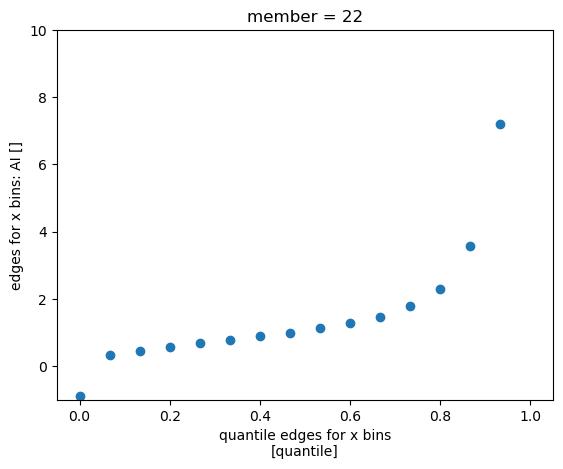

In [ ]:
qbin[x_var].x_edge.sel(member=m).plot(marker="o", lw=0)
plt.ylim(-1, 10)
print(qbin[x_var].x_edge.sel(member=m).values)

In [ ]:
xbe

<xarray.DataArray 'x_bin' (year: 20, lat: 96, lon: 144)> Size: 2MB
dask.array<getitem, shape=(20, 96, 144), dtype=float64, chunksize=(20, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 160B 1995 1996 1997 1998 1999 ... 2011 2012 2013 2014
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    member   int64 8B 22
Attributes:
    long_name:      gridcell x bin index: AI
    x_long_name:    aridity index PET/P, higher is more arid
    x_time_mean:    1995-01 to 2014-12
    units:          index
    x_description:  Rn / (Lv * P), filtered P = max(P, 0.001) [W/m2]

In [ ]:
nb = 15
mask_type = "mask_glc80_snow80"
qbin_variables = [
    "AI_clim_1",

    "TLAI_month_1",
    "TLAI_year_1",
    "TLAI_clim_1",

    "GROWSN_TLAI_year_1",
    "GROWSN_TLAI_clim_1",

    "TOTANNPRECT_year_1",
    # "TOTANNPRECT_clim_1",

    "TSA_year_1",
    # "TSA_clim_1",
]
rootdir = Path("/glade/work/bbuchovecky/et_controls/proc/qbin")

qbin = {}
for v in qbin_variables:
    qbin[v] = xr.open_mfdataset(
        list((rootdir / mask_type / v).glob(f"qbin{nb}.1995-2014.TIMEagg.{v}.*.nc")),
        combine="nested",
        concat_dim="member",
    ).sortby("member").reindex_like(grid, method="nearest", tolerance=1e-3)

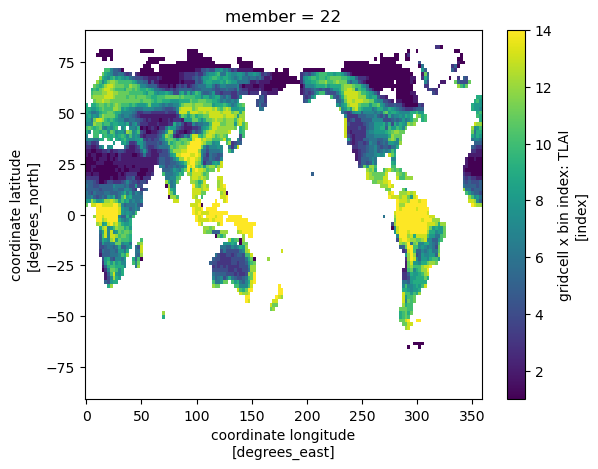

In [ ]:
qbin["TLAI_clim_1"].x_bin.sel(member=m).plot()

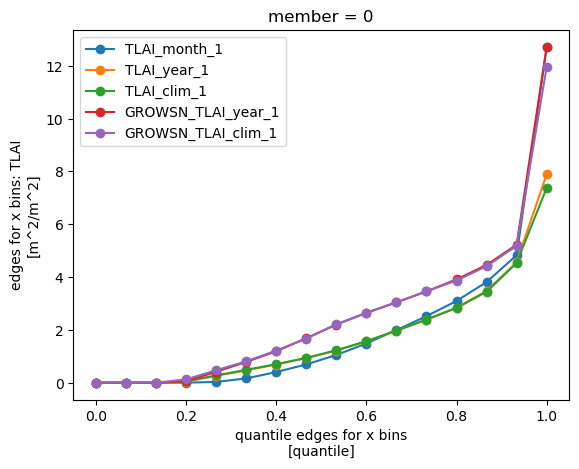

In [ ]:
qbin["TLAI_month_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="TLAI_month_1")
qbin["TLAI_year_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="TLAI_year_1")
qbin["TLAI_clim_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="TLAI_clim_1")
qbin["GROWSN_TLAI_year_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="GROWSN_TLAI_year_1")
qbin["GROWSN_TLAI_clim_1"].x_edge.isel(member=0).plot(marker="o", alpha=1, label="GROWSN_TLAI_clim_1")
plt.legend(loc="upper left")

In [ ]:
# z_var = "EFLX_LH_TOT_month_1"
# x_var = "AI_clim_1"
# y_var = "TLAI_clim_1"

# # Select data
# z = fhist[z_var].sel(member=slice(1, None)).drop_vars(['ltype', 'landunit']) - fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
# x_bin = qbin[x_var].sel(member=slice(1, None)).x_bin
# y_bin = qbin[y_var].sel(member=slice(1, None)).x_bin

# bs, sg = xclim.binned.full_bin_stats(z, x_bin, y_bin, nb, nb, z_time_coord="time")

# m = 2
# bs.sel(member=m, stats_name='mean').where(sg.sel(member=m)).plot(robust=True, center=0, cmap="RdBu_r")
# plt.show()
# bs.sel(member=m, stats_name='n').plot(robust=True, vmin=0)
# plt.show()

In [ ]:
# z_var = "EFLX_LH_TOT_month_1"
# x_var = "AI_clim_1"
# y_var = "TLAI_month_1"

# # Select data
# z = fhist[z_var].sel(member=slice(1, None)).drop_vars(['ltype', 'landunit']) - fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
# x_bin = qbin[x_var].sel(member=slice(1, None)).x_bin
# y_bin = qbin[y_var].sel(member=slice(1, None)).x_bin

# bs, sg = xclim.binned.full_bin_stats(z, x_bin, y_bin, nb, nb, z_time_coord="time")

# m = 2
# bs.sel(member=m, stats_name='mean').where(sg.sel(member=m)).plot(robust=True, center=0, cmap="RdBu_r")
# plt.show()
# bs.sel(member=m, stats_name='n').plot(robust=True, vmin=0)
# plt.show()

In [ ]:
# z_var = "EFLX_LH_TOT_month_1"
# x_var = "AI_clim_1"
# y_var = "TLAI_month_1"

z_var = "EFLX_LH_TOT_year_1"
x_var = "AI_clim_1"
y_var = "TLAI_year_1"

# z_var = "EFLX_LH_TOT_year_1"
# x_var = "TSA_year_1"
# y_var = "TOTANNPRECT_year_1"

# Select data
z = fhist[z_var].sel(member=slice(1, None)).drop_vars(['ltype', 'landunit']) - fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
x_bin = qbin[x_var].sel(member=slice(1, None)).x_bin
y_bin = qbin[y_var].sel(member=slice(1, None)).x_bin
bs, sg = xclim.binned.full_bin_stats(z, x_bin, y_bin, nb, nb, z_time_coord="year", alpha=0.05, n_min=40)

bs = bs.compute()
sg = sg.compute()

In [ ]:
z_time_coord = "year"

if z_time_coord not in x_bin.dims:
    x_bin_expand = x_bin.expand_dims({z_time_coord: z[z_time_coord]})
else:
    x_bin_expand = x_bin

if z_time_coord not in y_bin.dims:
    y_bin_expand = y_bin.expand_dims({z_time_coord: z[z_time_coord]})
else:
    y_bin_expand = y_bin

assert x_bin_expand[z_time_coord].shape == z[z_time_coord].shape
assert y_bin_expand[z_time_coord].shape == z[z_time_coord].shape

In [ ]:
m = 22

xb = x_bin.sel(member=m)
yb = y_bin.sel(member=m)
xbe = x_bin_expand.sel(member=m)
ybe = y_bin_expand.sel(member=m)
jh = bs.sel(member=m, stats_name="n")

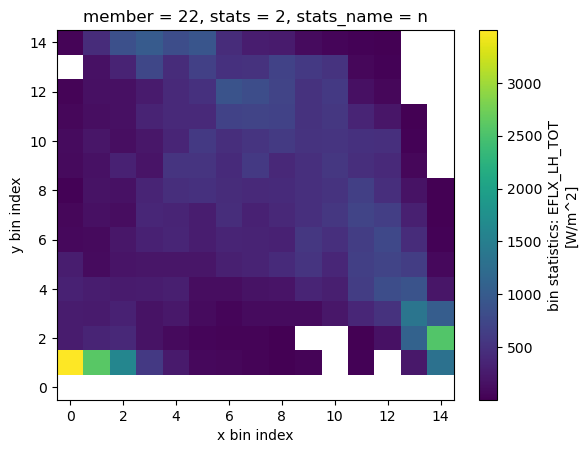

In [ ]:
jh.plot()
# jh.where(sg.sel(member=m)).plot()

In [ ]:
jh.sum(dim="ibx").max() / 2

<xarray.DataArray 'bin_stats' ()> Size: 8B
array(5150.5)
Coordinates:
    member      int64 8B 22
    stats       int64 8B 2
    stats_name  <U6 24B 'n'
Attributes:
    long_name:  bin statistics: EFLX_LH_TOT
    units:      W/m^2

([<matplotlib.axis.YTick at 0x7f654c12e8a0>,
 [Text(0, 0.0, '0'), Text(0, 5150.5, '5150'), Text(0, 10301.0, '10301')])

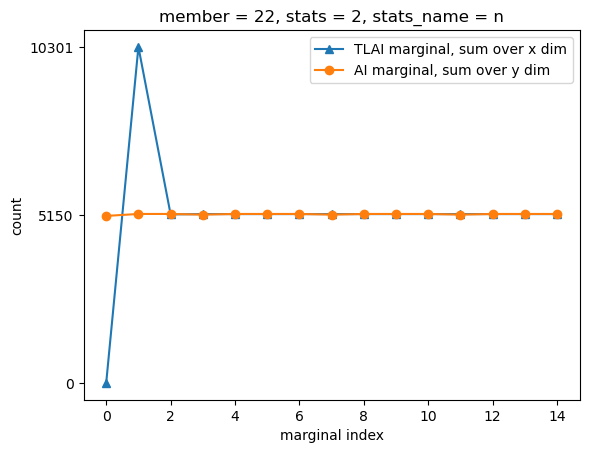

In [ ]:
jh.sum(dim="ibx").plot(marker="^", label="TLAI marginal, sum over x dim")
jh.sum(dim="iby").plot(marker="o", label="AI marginal, sum over y dim")
plt.xlabel("marginal index")
plt.ylabel("count")
plt.legend()
plt.yticks([0, jh.sum(dim="ibx").max() / 2, jh.sum(dim="ibx").max()])

In [ ]:
jh.sum(dim=['iby', 'ibx']).values
# jh.where(sg.sel(member=m)).sum(dim=['iby', 'ibx']).values

array(77580.)

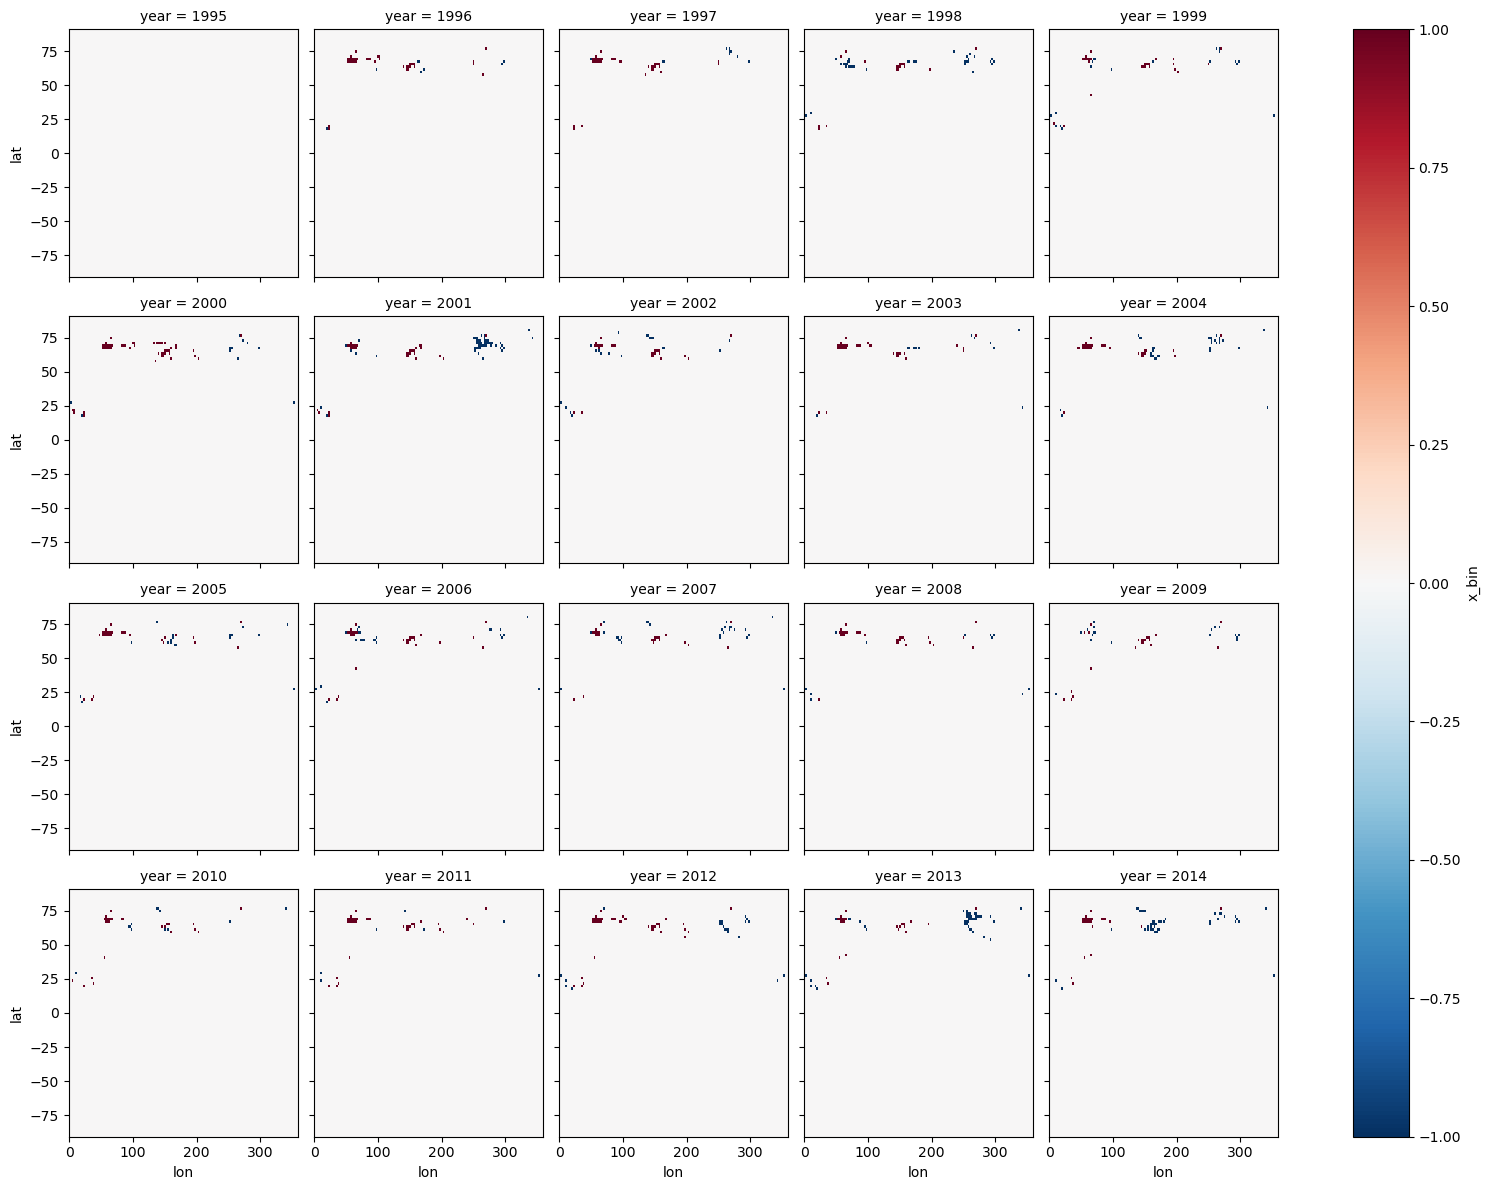

In [ ]:
(xr.where(ybe == 1, 1, 0) - xr.where(ybe.isel(year=0) == 1, 1, 0)).plot.pcolormesh(
    col="year",
    col_wrap=5,
)
# Note: no significant spatial shifts in lowest TLAI quantile over the time period

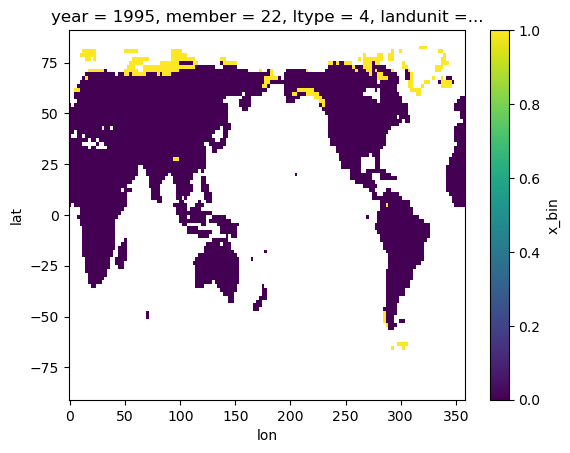

In [ ]:
xr.where(xbe == 0, 1, 0).where(full_mask.sel(member=m)).isel(year=0).plot.pcolormesh()

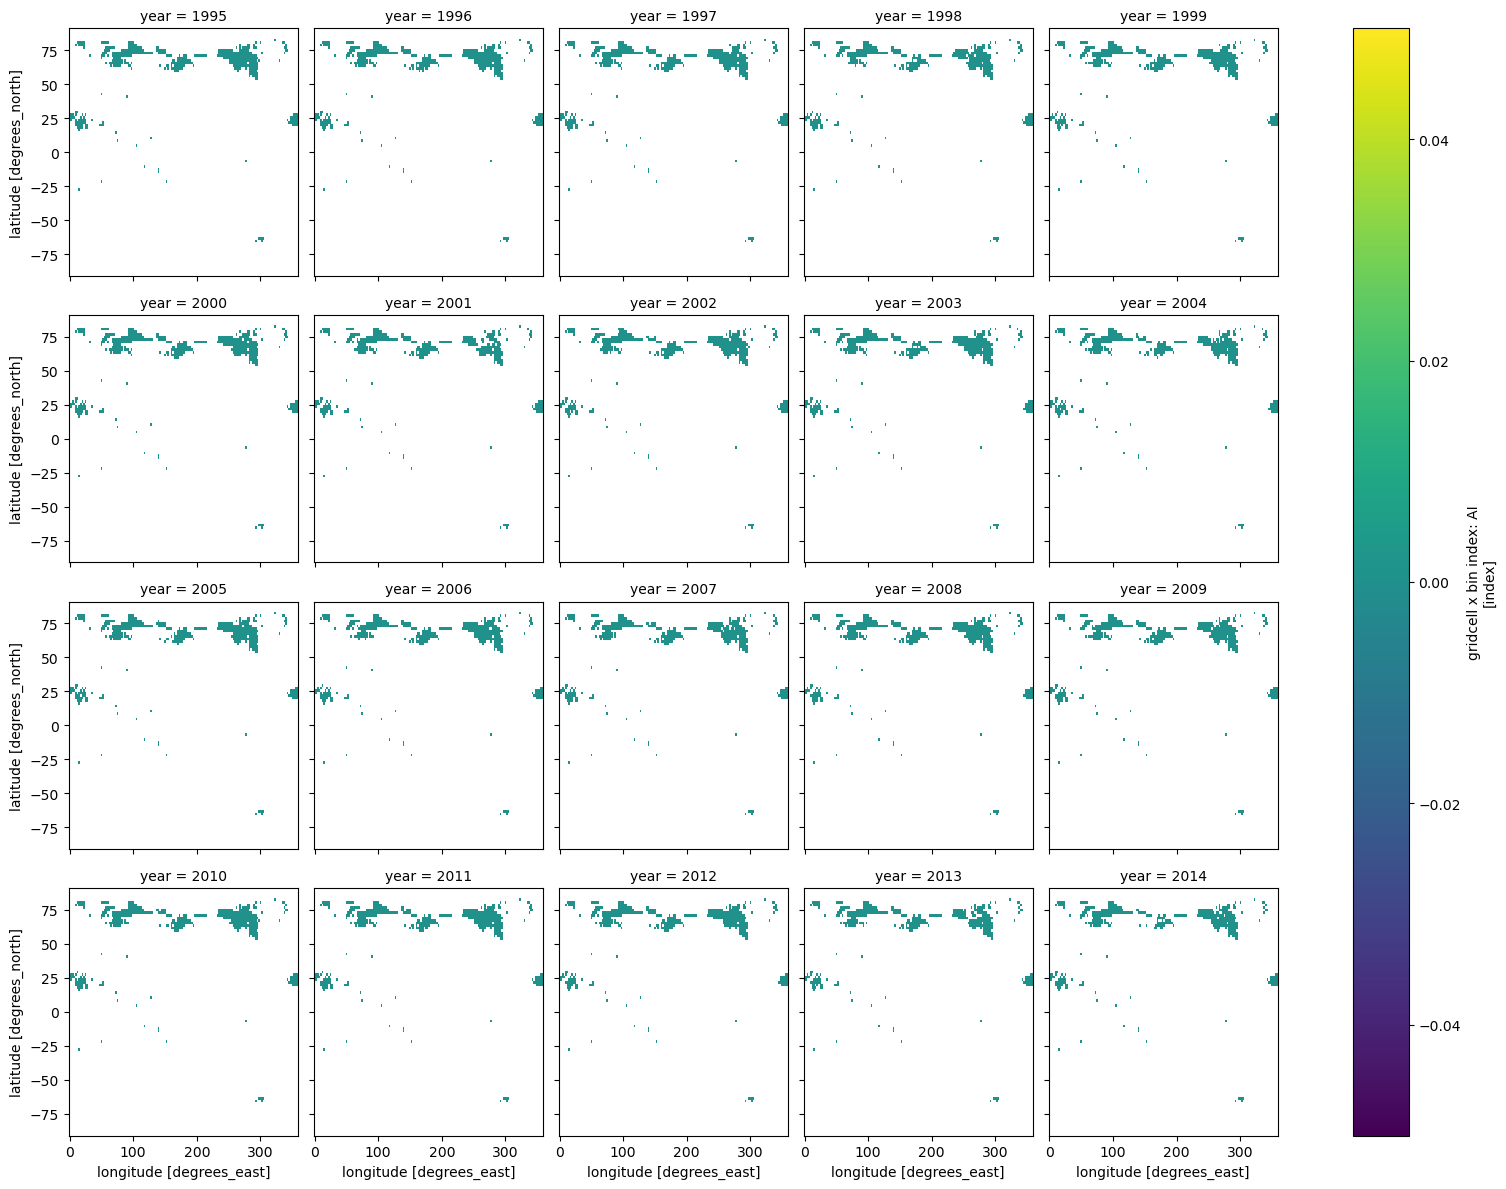

In [ ]:
# xbe.isel(year=0).plot.pcolormesh()

# xbe.where((xbe == 0) & (y_bin_expand.isel(member=0) == 1)).plot.pcolormesh(
#     col="year",
#     col_wrap=5,
# )

# xbe.where((xbe == 0)).plot.pcolormesh(
#     col="year",
#     col_wrap=5,
# )

(xbe.where((ybe == 1)) - xbe.isel(year=0).where((ybe.isel(year=0) == 1))).plot.pcolormesh(
    col="year",
    col_wrap=5,
)

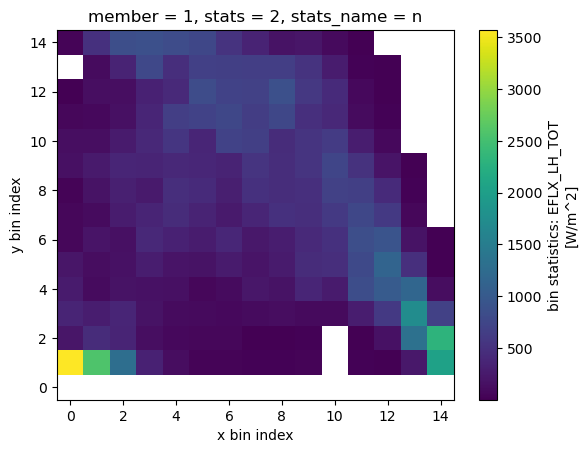

In [ ]:
jh.isel(member=0).plot()

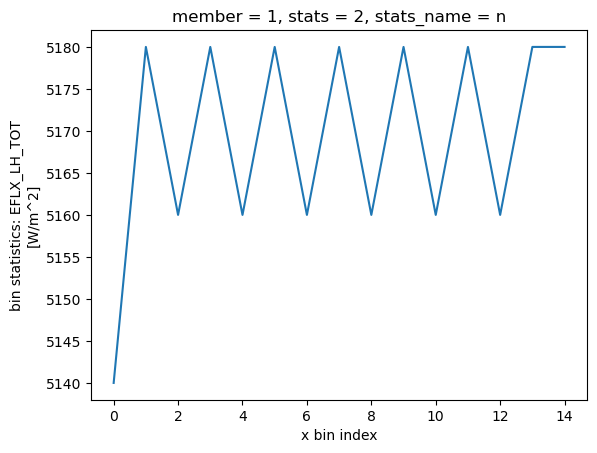

In [ ]:
jh.isel(member=0).sum(dim='iby').plot()

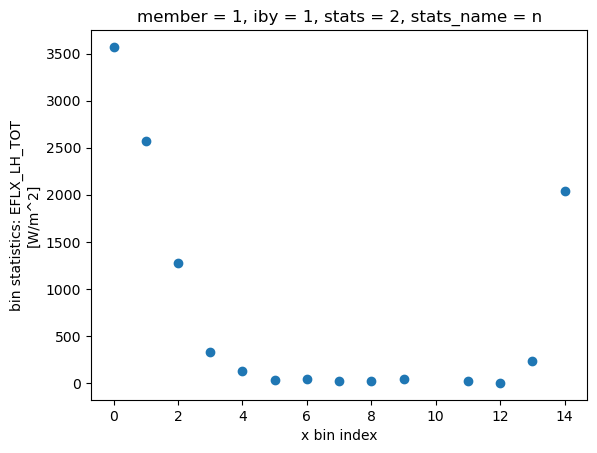

In [ ]:
jh.isel(member=0, iby=1).plot(lw=0, marker="o")

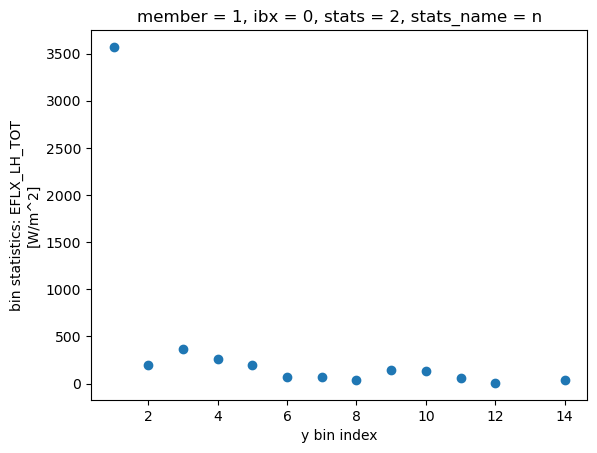

In [ ]:
jh.isel(member=0, ibx=0).plot(lw=0, marker="o")

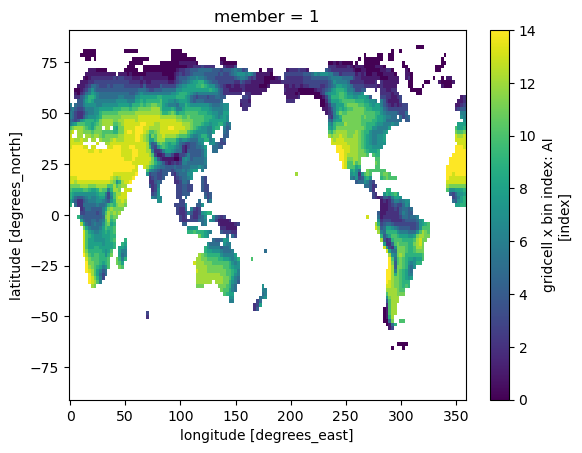

In [ ]:
x_bin.isel(member=0).plot()

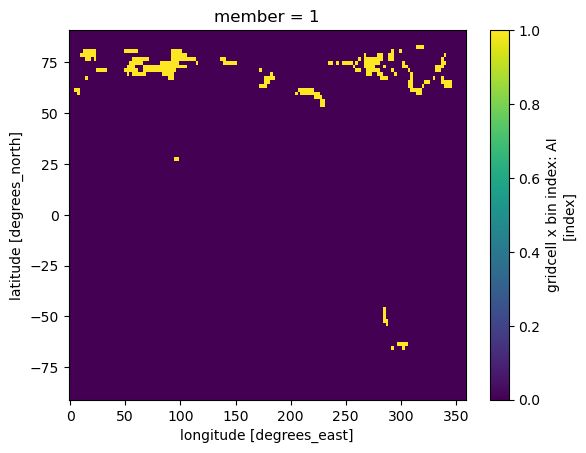

In [ ]:
(x_bin.isel(member=0) == 0).plot()

In [ ]:
(x_bin.isel(member=0) == 0).sum().values

array(259)

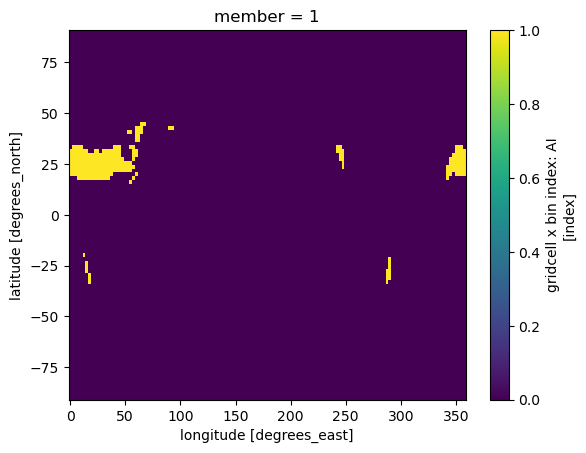

In [ ]:
(x_bin.isel(member=0) == 14).plot()

In [ ]:
(x_bin.isel(member=0) == 14).sum().values

array(259)